### DPW Operations

In [21]:
DPW_Ops = df[df['agency_responsible'] == 'DPW Ops Queue']

In [22]:
DPW_Ops.head()

,Date,agency_responsible
9402,2020-12-31,DPW Ops Queue
9405,2020-12-31,DPW Ops Queue
9411,2020-12-31,DPW Ops Queue
9422,2020-12-31,DPW Ops Queue
9427,2020-12-31,DPW Ops Queue


In [23]:
DPW_Ops.agency_responsible = 1

In [24]:
DPW_Ops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861172 entries, 9402 to 2419346
Data columns (total 2 columns):
Date                  861172 non-null datetime64[ns]
agency_responsible    861172 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 MB


In [25]:
DPW_Ops.set_index('Date', inplace = True)

In [26]:
#queens_grouped = ny.groupby(['Zipcode'], as_index = True).resample('M').sum()

In [27]:
DPW_Ops_grouped = DPW_Ops.groupby(['Date'], as_index = False).resample('M').sum()

In [28]:
DPW_Ops_grouped.head()

,,agency_responsible
,Date,
0,2017-01-31,403
1,2017-01-31,440
2,2017-01-31,645
3,2017-01-31,663
4,2017-01-31,440


### Grouping by Month

In [29]:
DPW_Ops_grouped = pd.DataFrame(DPW_Ops_grouped)

In [30]:
DPW_Ops_grouped.head()

,,agency_responsible
,Date,
0,2017-01-31,403
1,2017-01-31,440
2,2017-01-31,645
3,2017-01-31,663
4,2017-01-31,440


In [31]:
DPW_Ops_grouped = DPW_Ops_grouped.groupby('Date').sum()

In [32]:
DPW_Ops_grouped.head()

,agency_responsible
Date,
2017-01-31,15106
2017-02-28,13367
2017-03-31,16537
2017-04-30,15057
2017-05-31,16287


In [33]:
DPW_Ops_grouped.tail()

,agency_responsible
Date,
2020-08-31,22237
2020-09-30,23775
2020-10-31,23751
2020-11-30,21216
2020-12-31,22607


### ACF & PACF

 - The time series shows a lot of noise.
 - The ACF graph shows trends every 12 months reflecting seasonality. 
 - The PACF graph cuts off after one.

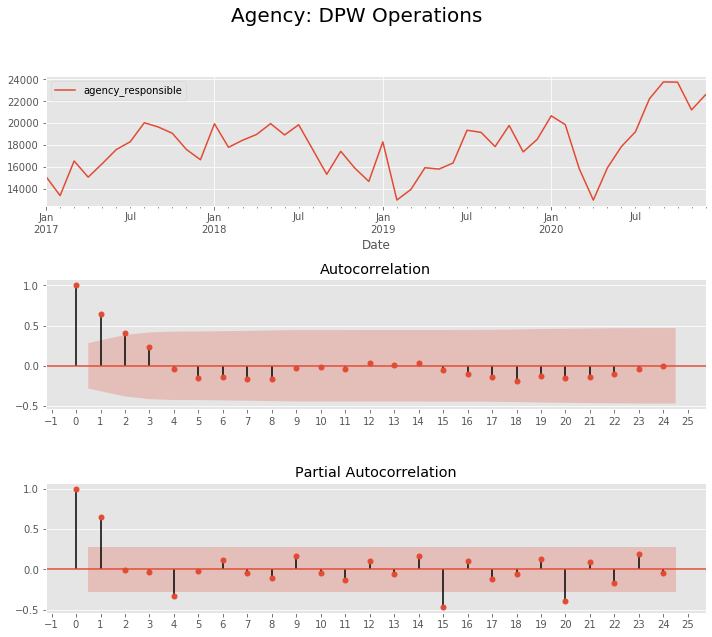

In [34]:
plot_acf_pacf(DPW_Ops_grouped, agency = 'DPW Operations')
plt.show()

### Decompose Time Series

The decomposed time series shows a significant dip and peak toward the turn of the year. 

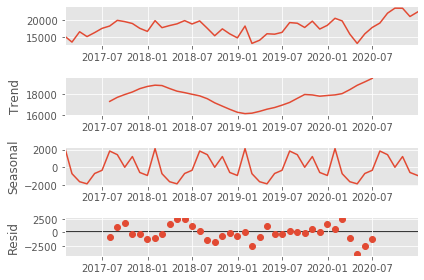

In [35]:
decompose_result = seasonal_decompose(DPW_Ops_grouped, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Testing with the Dicky-Fuller Test

P-value shows a lack of stationarity. 

In [36]:
dftest = adfuller(DPW_Ops_grouped.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.7483704917349217
2. P-Value :  0.06603549720451096
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 47
5. Critical Values :
	 1% :  -3.5778480370438146
	 5% :  -2.925338105429433
	 10% :  -2.6007735310095064


### Using Differencing with Mean Rolled Time Series for Seasonality

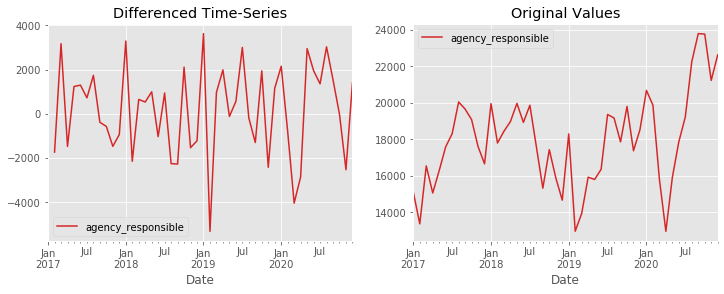

In [37]:
DPW_Ops_grouped_diff = DPW_Ops_grouped - DPW_Ops_grouped.shift()

ax1 = plt.subplot(121)
DPW_Ops_grouped_diff.plot(figsize=(8,4), color="tab:red", title="Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
DPW_Ops_grouped.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Retesting with the Dicky-Fuller Test

Correcting for seasonality by differencing with the mean rolled time series made the time series less stationary. 

In [38]:
dftest = adfuller(DPW_Ops_grouped_diff.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.177694282268169
2. P-Value :  8.291304329127733e-13
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 46
5. Critical Values :
	 1% :  -3.5812576580093696
	 5% :  -2.9267849124681518
	 10% :  -2.6015409829867675


### Correcting the Original Time Series for Trend with the Moving Window Function

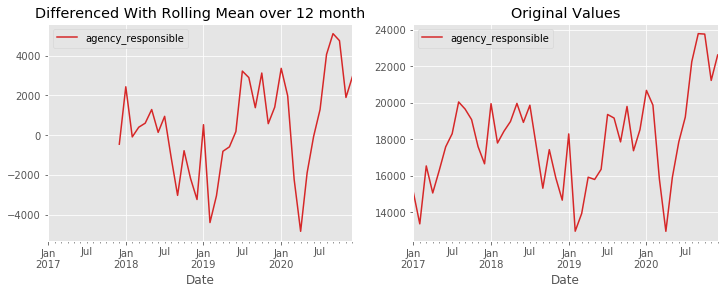

In [39]:
rolling_mean = DPW_Ops_grouped.rolling(window = 12).mean()
DPW_Ops_grouped_detrended = DPW_Ops_grouped - rolling_mean

ax1 = plt.subplot(121)
DPW_Ops_grouped_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
DPW_Ops_grouped.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Retesting with the Dicky-Fuller Test

Correcting for trend decreased the stationarity of the time series. 

In [40]:
dftest = adfuller(DPW_Ops_grouped_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.7287920103233865
2. P-Value :  0.06918712943176285
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 36
5. Critical Values :
	 1% :  -3.626651907578875
	 5% :  -2.9459512825788754
	 10% :  -2.6116707716049383


### SARIMAX Modeling: Parameter Selection

Since altering the time series only increased the p-value, the original time series will be used. 

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [42]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(DPW_Ops_grouped,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

### Fitting the Time Series Model - SARIMAX

Changing enforce_stationarity to True allows the plot diagnostics to be called. 

In [43]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

In [44]:
best_params = dict(ans_df.loc[ans_df['aic'].idxmin()])
best_params

{'pdq': (0, 0, 0), 'pdqs': (0, 2, 2, 12), 'aic': 6.0}

In [45]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(DPW_Ops_grouped, 
                                        order= best_params['pdq'], 
                                        seasonal_order=best_params['pdqs'], 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:            agency_responsible   No. Observations:                   48
Model:             SARIMAX(0, 2, [1, 2], 12)   Log Likelihood                -234.687
Date:                       Sat, 16 Jan 2021   AIC                            475.373
Time:                               15:40:46   BIC                            478.907
Sample:                           01-31-2017   HQIC                           476.311
                                - 12-31-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.4237      0.513     -0.826      0.409      -1.429       0.582
ma.S.L24      -0.2986      0.243     -1.228      0.220      -0.775       0.178
sigma2      2.517e+07   1.74e-08   1.45e+15      0.000    2.52e+07    2.52e+07
===================================================================================
Ljung-Box (Q):                       52.47   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.08   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.32e+30. Standard errors may be unstable.
"""

### Plot Diagnostics

- The standardized residual seems to show noise rather than a pattern.
- The histogram is normally distributed.
- The points on the QQ plot follow the line closely. 
- The points in the correlogram fall inside the box and do not indidcate a missed seasonality component. 

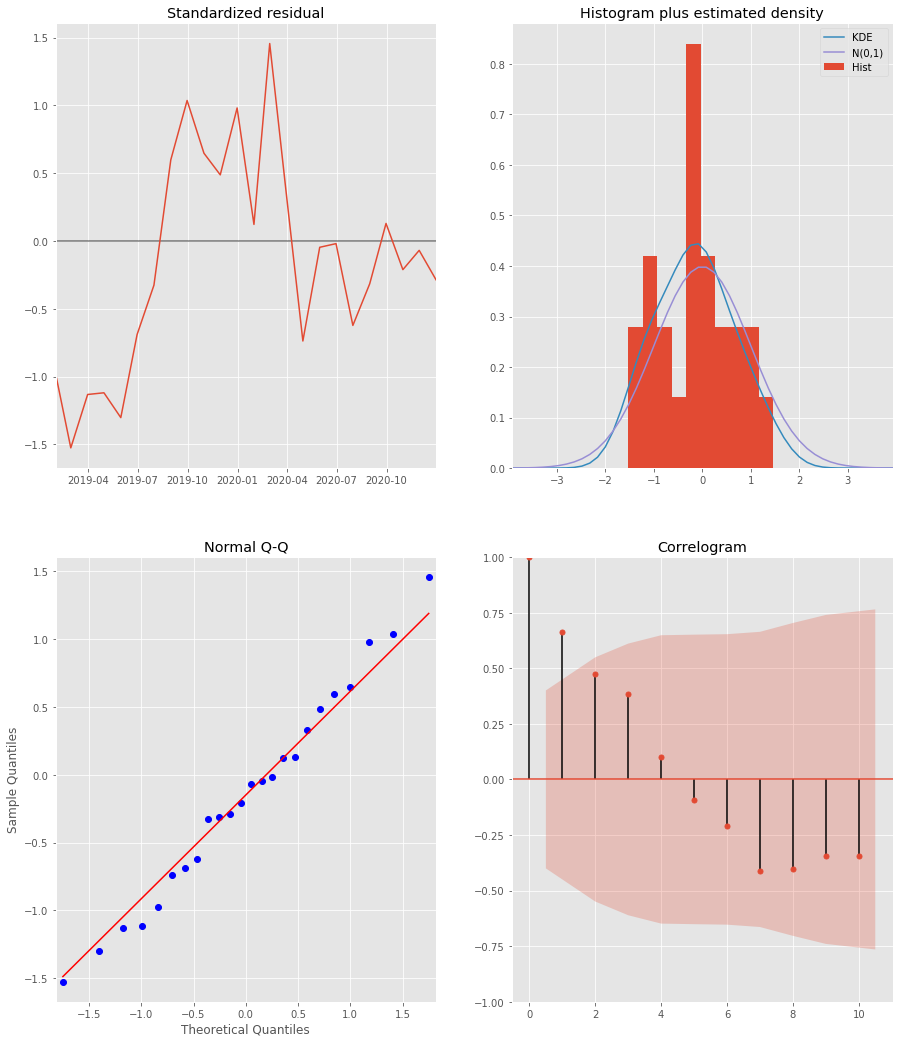

In [46]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 10 steps before the end of the time series. This number will change as the time series expands.

In [47]:
full_set = DPW_Ops_grouped.size

In [48]:
eighty_percent = (full_set * .2).round(0)

In [49]:
threshold = full_set - eighty_percent

In [50]:
threshold

38.0

### Testing and Training Breakpoint

The time series will be sliced at 2020-03-31.

In [51]:
DPW_Ops_grouped[38:]

,agency_responsible
Date,
2020-03-31,15816
2020-04-30,12959
2020-05-31,15907
2020-06-30,17858
2020-07-31,19210
2020-08-31,22237
2020-09-30,23775
2020-10-31,23751
2020-11-30,21216


In [52]:
pred = output.get_prediction(start=pd.to_datetime('2020-03-31'), dynamic=False)
pred_conf = pred.conf_int()

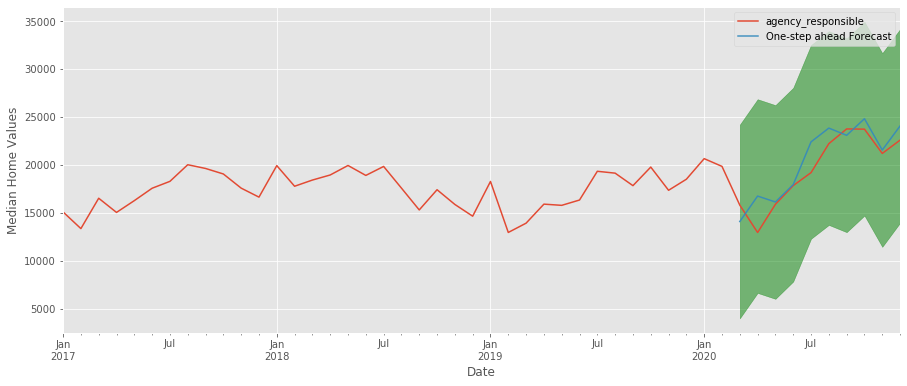

In [53]:

rcParams['figure.figsize'] = 15, 6

ax = DPW_Ops_grouped['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with RMSE (Root Mean Squared Error)

In [54]:
val_forecasted = pred.predicted_mean
val_truth = DPW_Ops_grouped.loc['2020-03-31':].agency_responsible

mse = np.sqrt(((val_forecasted - val_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1854.0


### Model Validation - Dynamic Forecasting

In [55]:
pred_dynamic = output.get_forecast(steps = 12)
pred_dynamic_conf = pred_dynamic.conf_int()


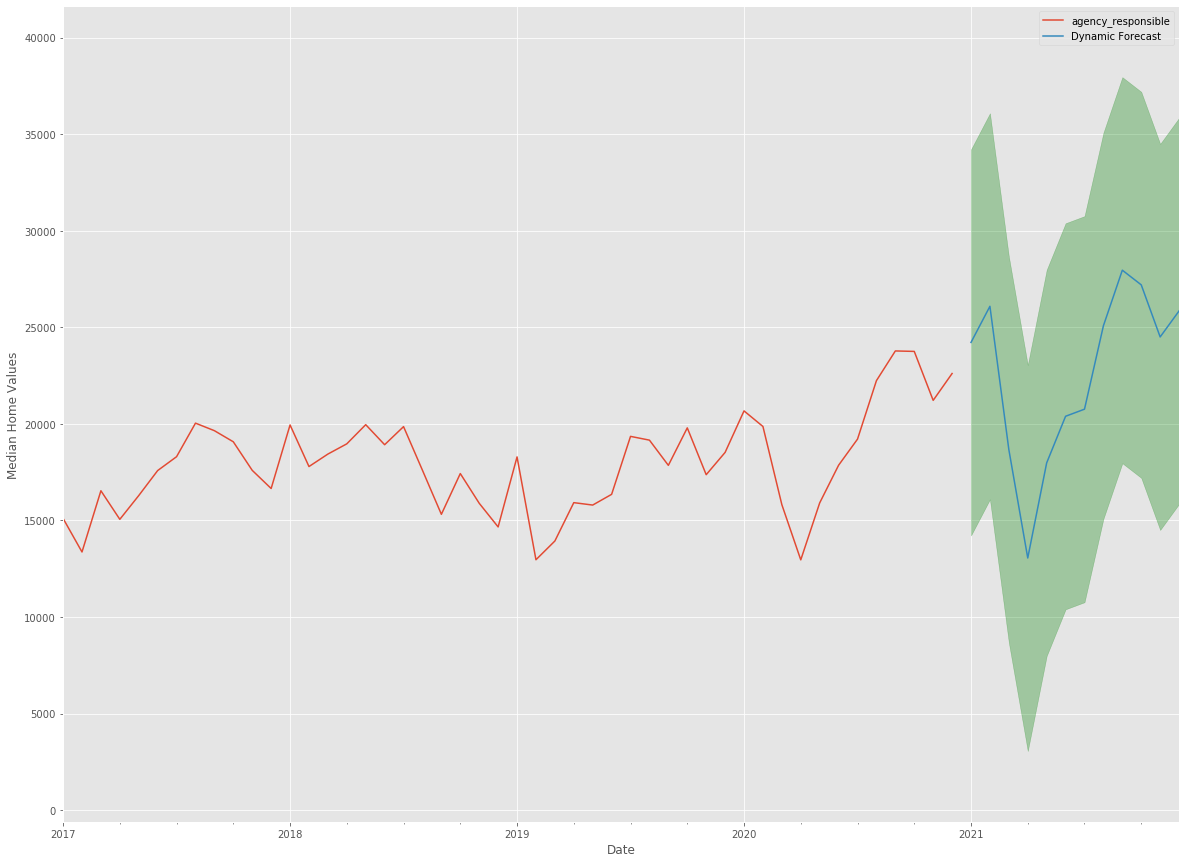

In [56]:
ax = DPW_Ops_grouped['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-12-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


### Visualizing Confidence Interval

In [57]:
# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower agency_responsible,upper agency_responsible,mean
2021-01-31,14221.184332,34209.060428,24215.122380
2021-02-28,16092.697693,36080.573789,26086.635741
2021-03-31,8675.425517,28663.301613,18669.363565
2021-04-30,3060.733019,23048.609115,13054.671067
2021-05-31,7984.606565,27972.482661,17978.544613


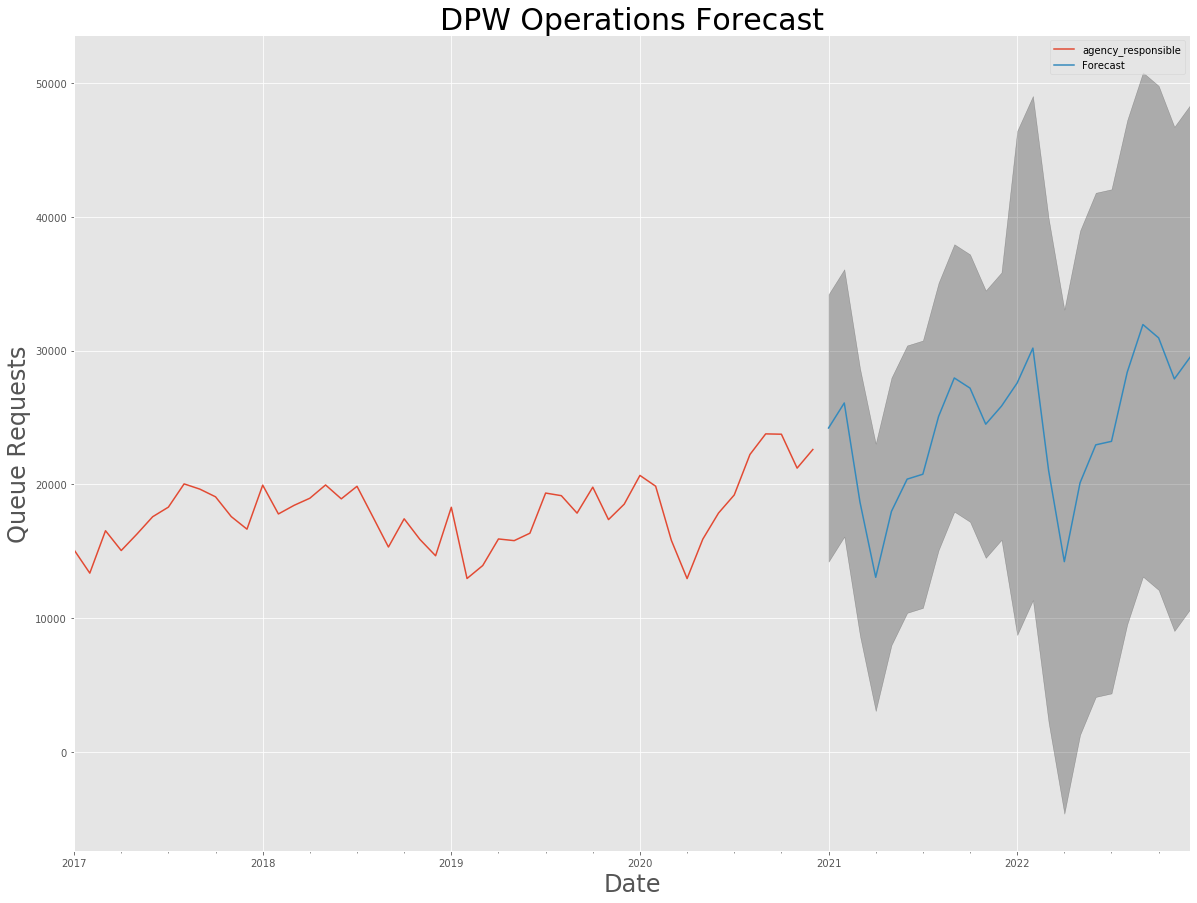

In [58]:
ax = DPW_Ops_grouped.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date', fontdict={'fontsize' : 24})
ax.set_ylabel('Queue Requests', fontdict={'fontsize' : 24})
ax.set_title('DPW Operations Forecast', fontdict={'fontsize' : 30})

plt.legend()
plt.show()

### DPW Operations Conclusion

The increase from the beginning of the time period to the end is 

In [65]:
Difference = DPW_Ops_grouped.agency_responsible[-1] - DPW_Ops_grouped.agency_responsible[0]

In [66]:
Difference

7501

### Results Dataframe

In [92]:
results = pd.DataFrame.from_dict(top_agencies, orient = 'index')

In [93]:
results.head()

,0
DPW Ops Queue,0
Recology_Abandoned,1
Parking Enforcement Dispatch Queue,2
DPT Abandoned Vehicles Work Queue,3
HSOC Queue,4


### Setting Column Zero to Index

In [101]:
results = results.reset_index(0)

In [106]:
results = results.drop(columns = 0)

In [107]:
results.head()

,index,call_increase
0,DPW Ops Queue,7501
1,Recology_Abandoned,1
2,Parking Enforcement Dispatch Queue,1
3,DPT Abandoned Vehicles Work Queue,1
4,HSOC Queue,1


In [108]:
results['call_increase'] = 1

In [109]:
results.head()

,index,call_increase
0,DPW Ops Queue,1
1,Recology_Abandoned,1
2,Parking Enforcement Dispatch Queue,1
3,DPT Abandoned Vehicles Work Queue,1
4,HSOC Queue,1


In [110]:
results.call_increase[0] = Difference
results.head()

,index,call_increase
0,DPW Ops Queue,7501
1,Recology_Abandoned,1
2,Parking Enforcement Dispatch Queue,1
3,DPT Abandoned Vehicles Work Queue,1
4,HSOC Queue,1
